## Importing the Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords

from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

## Input Data and Pre-processing

In [2]:
df=pd.read_csv('AUD_Final_craig_new.csv')

In [3]:
df.head()

,Label,Product_Url,Content,header
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia)
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...


In [4]:
print('The number of rows and columns in the dataset are:',df.shape)

The number of rows and columns in the dataset are: (2143, 4)


                Count  Percentage
Computer         1287   60.055996
Not a Computer    856   39.944004


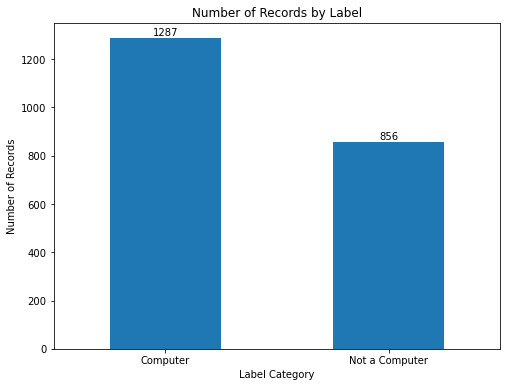

In [5]:
value_counts=df['Label'].value_counts()
percentage=(value_counts/len(df))*100
result=pd.DataFrame({'Count': value_counts, 'Percentage': percentage})
print(result)

result['Count'].plot(kind='bar', figsize=(8, 6))
plt.title('Number of Records by Label')
plt.xlabel('Label Category')
plt.ylabel('Number of Records')

for i, count in enumerate(result['Count']):
    plt.text(i, count + 10, str(count), ha='center')

plt.xticks(rotation=0)

plt.show()

In [6]:
null_check = df.isnull().any()
percentage_null = (df.isnull().mean()) * 100
result = pd.DataFrame({'Has Null': null_check, 'Percentage Null': percentage_null})

print(result)

             Has Null  Percentage Null
Label           False         0.000000
Product_Url     False         0.000000
Content          True         0.233318
header           True         4.433038


In [7]:
#Extracting the key words from the Product_Url to use it for classification
extracted_url=[]
for i in range(0,len(df)):
    start_index=df['Product_Url'][i].find('/d/')
    end_index=df['Product_Url'][i].rfind('/')
    extracted_url.append(df['Product_Url'][i][start_index+3:end_index])

In [8]:
#Replacing '-' with ' ' to enable tokenization in the later stage
df['Extracted_URL']=extracted_url
df.loc[:, 'Extracted_URL'] = df['Extracted_URL'].str.replace('-', ' ')

In [9]:
df.head()

,Label,Product_Url,Content,header,Extracted_URL
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port


In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df['Flag'] = labelencoder.fit_transform(df['Label'])

In [11]:
df.head()

,Label,Product_Url,Content,header,Extracted_URL,Flag
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger,1
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector,1
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless,1
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full,1
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port,1


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/khande28/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Tokenize the collection
token_list = []
for i in df['Extracted_URL']:
    # Handle missing values
    if pd.notnull(i):
        token_list.append(nltk.word_tokenize(i))

# Lemmatize the words
lammetize_list = []
for i in token_list:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_token = [lemmatizer.lemmatize(token) for token in i]
    lammetize_list.append(lemmatized_token)

# Remove stop words
stop_list = []
for i in lammetize_list:
    stop_words_removed = [token for token in i if not token in stopwords.words('english') if token.isalnum() and token.lower() != 'nan']
    stop_list.append(stop_words_removed)

In [14]:
#Defining a function to again add the token back into a sentence
def convert_to_string(a): 
    
    # initialize an empty string
    first_string = "" 
    
    # traverse in the string  
    for element in a: 
        first_string = first_string+" "+element  
    
    # return string  
    return first_string 

In [15]:
final_list=[]
for i in stop_list:
    sen_list=convert_to_string(i)
    final_list.append(sen_list)

In [16]:
df2=pd.DataFrame(final_list,columns=['Cleaned_URL'])
df2

,Cleaned_URL
0,batavia apple mag safe charger
1,chicago macbook pro 16 screen protector
2,lisle nib brand new medion wireless
3,naperville new sealed hp laserjet full
4,naperville new sealed link port
...,...
2138,oakland compatible hp laserjet
2139,alameda vizio 26 computer monitor
2140,cupertino macbook pro 16 inch loaded m1
2141,fremont 2019 macbook pro 16 inch gb ssd


In [17]:
#Creating the final Dataframe
final=pd.merge(df,df2,left_index=True,right_index=True)
final.head()

,Label,Product_Url,Content,header,Extracted_URL,Flag,Cleaned_URL
0,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/batav...,"Very good shape, photo shows phone being charg...",Apple Mag Safe charger - $20 (Batavia),batavia apple mag safe charger,1,batavia apple mag safe charger
1,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/chica...,Ibenzer Anti Blue Light Anti Glare Screen Prot...,MacBook Pro 16 Screen Protector 2019-2020 - ...,chicago macbook pro 16 screen protector,1,chicago macbook pro 16 screen protector
2,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/lisle...,2 NIB Brand New Medion Wireless Keyboard and M...,NaN,lisle nib brand new medion wireless,1,lisle nib brand new medion wireless
3,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,"New, in box and sealed, HP LaserJet wireless m...",New Sealed HP LaserJet Full Duplex Wireless L...,naperville new sealed hp laserjet full,1,naperville new sealed hp laserjet full
4,Not a Computer,https://chicago.craigslist.org/nwc/sys/d/naper...,New and sealed in box D-Link 5-port 10/100 des...,New and Sealed D-Link 5 Port Desktop Switch ...,naperville new and sealed link port,1,naperville new sealed link port


## Models

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(final['Cleaned_URL'], final['Flag'], test_size=0.3, random_state=183, shuffle=True)

In [19]:
vectorizer=TfidfVectorizer(min_df=1,ngram_range=(1,2))
v1=vectorizer.fit(X_train)

X_train_transformed=vectorizer.transform(X_train)
X_test_transformed=vectorizer.transform(X_test)

In [20]:
X_train_transformed.shape

(1500, 5824)

In [21]:
X_test_transformed.shape

(643, 5824)

In [22]:
X_train.head()

941                   romeoville netgear cm1000
570       chicago apple macbook laptop Computer
1945      pleasanton apple macbook air ghz core
1162      mac mini 2014 i5 4278u 26ghz 8gb iris
590      chicago netgear wndr4500 n900 wireless
Name: Cleaned_URL, dtype: object

In [23]:
X_test.head()

1129            gilroy pfsense router firewall
388             villa park 2020 macbook air 13
367         melrose park microsoft surface pro
135                   chicago mac mini m2 2023
26       schaumburg i7 dell precision 5720 aio
Name: Cleaned_URL, dtype: object

## 1. Logistic Regression

In [24]:
Logit_model = LogisticRegression()
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=Logit_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
Logit_model_best = LogisticRegression(**best_params)
Logit_model_best.fit(X_train_transformed, Y_train)

y_pred_logit_best = Logit_model_best.predict(X_test_transformed)
accuracy_logit_best = accuracy_score(Y_test, y_pred_logit_best)
print("Accuracy of Logit model with best parameters: {:.4f}%".format(accuracy_logit_best * 100))

y_pred_prob_logit_best = Logit_model_best.predict_proba(X_test_transformed)
print(y_pred_prob_logit_best[0])

Best parameters: {'C': 10, 'penalty': 'l2'}
Accuracy of Logit model with best parameters: 86.1586%
[0.10924739 0.89075261]


## 2. Naive Bayes

In [25]:
# Define the model
NB_model = MultinomialNB()

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Perform grid search
grid_search = GridSearchCV(NB_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameter
best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

# Train the model with the best alpha
NB_model_best = MultinomialNB(alpha=best_alpha)
NB_model_best.fit(X_train_transformed, Y_train)

# Evaluation
y_pred_NB_best = NB_model_best.predict(X_test_transformed)
accuracy_NB_best = accuracy_score(Y_test, y_pred_NB_best)
print("Accuracy of Naive Bayes model with best alpha: {:.4f}%".format(accuracy_NB_best * 100))

print(classification_report(y_pred_NB_best,Y_test))
print(confusion_matrix(y_pred_NB_best,Y_test))

Best alpha value: 0.1
Accuracy of Naive Bayes model with best alpha: 86.3142%
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       418
           1       0.77      0.87      0.82       225

    accuracy                           0.86       643
   macro avg       0.85      0.86      0.85       643
weighted avg       0.87      0.86      0.86       643

[[360  58]
 [ 30 195]]


## 3. XGBoost

In [36]:
xgboost_model = XGBClassifier(random_state=0)
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9],
}

# Perform grid search
grid_search = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
xgboost_model_best = XGBClassifier(**best_params, random_state=0)
xgboost_model_best.fit(X_train_transformed, Y_train)

# Evaluation
y_pred_xgboost_best = xgboost_model_best.predict(X_test_transformed)
accuracy_xgboost_best = accuracy_score(Y_test, y_pred_xgboost_best)
print("Accuracy of XGBoost Classifier Model with best parameters: {:.4f}%".format(accuracy_xgboost_best * 100))

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy of XGBoost Classifier Model with best parameters: 83.5148%


## 4. ANN

In [32]:
# Split your data into a training and a validation set
X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(X_train_transformed, Y_train, test_size=0.2, random_state=42)

# Create the MLPClassifier with early stopping
DeepLearning_model = MLPClassifier(
    solver='adam', 
    hidden_layer_sizes=(150, 100, 50),  # Example: Three hidden layers
    activation='relu', 
    random_state=42,
    early_stopping=True, 
    validation_fraction=0.1,  # Fraction of training data to use as validation
    n_iter_no_change=10       # Stop training if validation score is not improving for 10 consecutive epochs
)

# Training
DeepLearning_model.fit(X_train_transformed, Y_train)

# Evaluation on the validation set
y_pred_val = DeepLearning_model.predict(X_test_transformed)
accuracy_dl_best = accuracy_score(Y_test, y_pred_val)
print("Accuracy of Deep Learning model: {:.4f}%".format(accuracy_dl_best * 100))


Accuracy of Deep Learning model: 86.1586%


## 5. Decision Tree

In [31]:
DecisionTree_model = DecisionTreeClassifier(min_samples_leaf=15,random_state=0) ## number of trees and number of layers/depth

#training
DecisionTree_model.fit(X_train_transformed, Y_train)
y_pred_DecisionTree = DecisionTree_model.predict(X_test_transformed)

#evaluation
accuracy_dt_best = accuracy_score(Y_test, y_pred_DecisionTree)
print("Decision Tree Model Accuracy: {:.4f}%".format(accuracy_dt_best*100))

y_pred_prob_dt_model = DecisionTree_model.predict_proba(X_test_transformed)
print(y_pred_prob_dt_model[0])

Decision Tree Model Accuracy: 80.0933%
[0.26582278 0.73417722]


# 6. Random Forest

In [33]:
def objective(trial):
    # Define the hyperparameter configuration space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Define a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('rf', RandomForestClassifier(n_estimators=n_estimators, 
                                      max_depth=max_depth, 
                                      bootstrap=bootstrap, 
                                      n_jobs=-1, 
                                      random_state=0))
    ])

    # Train the model
    pipeline.fit(X_train_transformed, Y_train)

    # Make predictions and evaluate the model
    y_pred = pipeline.predict(X_test_transformed)
    accuracy = accuracy_score(Y_test, y_pred)
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best model after optimization
best_params = study.best_params
print("Best parameters:", best_params)

# Train the best model
best_model = RandomForestClassifier(**best_params, random_state=0)
best_model.fit(X_train_transformed, Y_train)

# Prediction and evaluation
y_pred = best_model.predict(X_test_transformed)
accuracy_rf_best = accuracy_score(Y_test, y_pred)
print("Random Forest Model Accuracy: {:.4f}%".format(accuracy_rf_best * 100))

# Probability prediction (if needed)
y_pred_prob = best_model.predict_proba(X_test_transformed)
print(y_pred_prob[0])

# Optional: Feature Importance Analysis
importances = best_model.feature_importances_

[I 2024-01-16 15:05:17,822] A new study created in memory with name: no-name-7ad26c4d-f1bb-4b4e-9c0e-c8f3605353ec
[I 2024-01-16 15:05:21,602] Trial 0 finished with value: 0.8289269051321928 and parameters: {'n_estimators': 366, 'max_depth': 24, 'bootstrap': False}. Best is trial 0 with value: 0.8289269051321928.
[I 2024-01-16 15:05:26,001] Trial 1 finished with value: 0.8320373250388803 and parameters: {'n_estimators': 453, 'max_depth': 26, 'bootstrap': False}. Best is trial 1 with value: 0.8320373250388803.
[I 2024-01-16 15:05:27,906] Trial 2 finished with value: 0.807153965785381 and parameters: {'n_estimators': 168, 'max_depth': 20, 'bootstrap': True}. Best is trial 1 with value: 0.8320373250388803.
[I 2024-01-16 15:05:30,515] Trial 3 finished with value: 0.8195956454121306 and parameters: {'n_estimators': 276, 'max_depth': 21, 'bootstrap': False}. Best is trial 1 with value: 0.8320373250388803.
[I 2024-01-16 15:05:32,002] Trial 4 finished with value: 0.8195956454121306 and paramete

Best parameters: {'n_estimators': 452, 'max_depth': 30, 'bootstrap': False}
Random Forest Model Accuracy: 83.5148%
[0.39902015 0.60097985]


## 7. LIGHT GBM

In [34]:
def objective(trial):
    param = {
        'objective': 'binary',  # Adjust for your task ('multiclass', etc.)
        'metric': 'binary_logloss',  # Adjust for your task ('multi_logloss', etc.)
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    lgbm = lgb.LGBMClassifier(**param)
    lgbm.fit(X_train_transformed, Y_train, 
             eval_set=(X_test_transformed, Y_test))
             #early_stopping_rounds=100, 
             #verbose=False)

    y_pred = lgbm.predict(X_test_transformed)
    accuracy = accuracy_score(Y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best parameters after optimization
best_params = study.best_params
print("Best parameters:", best_params)

# Train the best model with early stopping
best_lgbm = lgb.LGBMClassifier(**best_params,min_gain_to_split=0.05,verbose=-1)
best_lgbm.fit(X_train_transformed, Y_train,
              eval_set=(X_test_transformed, Y_test))
              #early_stopping_rounds=100,
              #verbose=False)

# Evaluation
y_pred_best = best_lgbm.predict(X_test_transformed)
accuracy_lgb_best = accuracy_score(Y_test, y_pred_best)
print("Improved LightGBM Model Accuracy: {:.4f}%".format(accuracy_lgb_best * 100))


[I 2024-01-16 15:13:21,018] A new study created in memory with name: no-name-e9bf0424-9f8f-4614-bf69-3285a94198a2
[I 2024-01-16 15:14:58,601] Trial 0 finished with value: 0.7947122861586314 and parameters: {'learning_rate': 0.26891454990758956, 'num_leaves': 127, 'max_depth': 42, 'min_child_samples': 41, 'max_bin': 377, 'subsample': 0.9654488752309527, 'subsample_freq': 3, 'colsample_bytree': 0.8653228059716056, 'reg_alpha': 2.1862041873571586e-06, 'reg_lambda': 5.276737425101657e-07}. Best is trial 0 with value: 0.7947122861586314.
[I 2024-01-16 15:15:26,611] Trial 1 finished with value: 0.7045101088646968 and parameters: {'learning_rate': 0.14568593347019781, 'num_leaves': 230, 'max_depth': 35, 'min_child_samples': 90, 'max_bin': 390, 'subsample': 0.776878619453065, 'subsample_freq': 1, 'colsample_bytree': 0.86493199787231, 'reg_alpha': 0.007721041021286693, 'reg_lambda': 1.8202263018095844e-08}. Best is trial 0 with value: 0.7947122861586314.
[I 2024-01-16 15:16:31,022] Trial 2 fini

Best parameters: {'learning_rate': 0.07168092950382213, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 11, 'max_bin': 293, 'subsample': 0.8786418429927852, 'subsample_freq': 5, 'colsample_bytree': 0.617445493510094, 'reg_alpha': 0.008013098277079835, 'reg_lambda': 0.09890540305582582}
Improved LightGBM Model Accuracy: 84.2924%


## 8. CatBoost

In [35]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'Logloss',
        'verbose': False,
        'random_state': 0
    }

    cat = CatBoostClassifier(**param)
    cat.fit(X_train_transformed, Y_train, verbose=0, early_stopping_rounds=50)

    y_pred = cat.predict(X_test_transformed)
    accuracy = accuracy_score(Y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best parameters after optimization
best_params = study.best_params
print("Best parameters:", best_params)

# Train the best model
best_cat = CatBoostClassifier(**best_params)
best_cat.fit(X_train_transformed, Y_train, verbose=20)

# Evaluation
y_pred_best_cat = best_cat.predict(X_test_transformed)
accuracy_cat_best = accuracy_score(Y_test, y_pred_best_cat)
print("Improved CatBoostClassifier Model Accuracy: {:.4f}%".format(accuracy_cat_best * 100))

[I 2024-01-16 16:19:27,051] A new study created in memory with name: no-name-2bbbc041-5285-4ff4-908d-b622ee9c898c
[I 2024-01-16 16:19:33,162] Trial 0 finished with value: 0.8491446345256609 and parameters: {'iterations': 231, 'depth': 7, 'learning_rate': 0.14086327322758466, 'random_strength': 2, 'bagging_temperature': 0.5803417547785574, 'l2_leaf_reg': 5.624330667527991e-06, 'border_count': 38}. Best is trial 0 with value: 0.8491446345256609.
[I 2024-01-16 16:20:35,118] Trial 1 finished with value: 0.8351477449455676 and parameters: {'iterations': 931, 'depth': 9, 'learning_rate': 0.16279109999755845, 'random_strength': 19, 'bagging_temperature': 0.2853861504021228, 'l2_leaf_reg': 4.123289259916402, 'border_count': 83}. Best is trial 0 with value: 0.8491446345256609.
[I 2024-01-16 16:20:41,023] Trial 2 finished with value: 0.8506998444790047 and parameters: {'iterations': 241, 'depth': 7, 'learning_rate': 0.2129574224419948, 'random_strength': 4, 'bagging_temperature': 0.5544804764552

Best parameters: {'iterations': 322, 'depth': 7, 'learning_rate': 0.217208911326632, 'random_strength': 4, 'bagging_temperature': 0.7042831617591276, 'l2_leaf_reg': 0.002531330867001478, 'border_count': 98}
0:	learn: 0.6461385	total: 14.3ms	remaining: 4.59s
20:	learn: 0.4060558	total: 489ms	remaining: 7.01s
40:	learn: 0.2971482	total: 967ms	remaining: 6.63s
60:	learn: 0.1642661	total: 1.4s	remaining: 6s
80:	learn: 0.0981052	total: 1.88s	remaining: 5.61s
100:	learn: 0.0594074	total: 2.37s	remaining: 5.18s
120:	learn: 0.0372368	total: 2.8s	remaining: 4.64s
140:	learn: 0.0255554	total: 3.28s	remaining: 4.21s
160:	learn: 0.0182804	total: 3.76s	remaining: 3.76s
180:	learn: 0.0136498	total: 4.19s	remaining: 3.26s
200:	learn: 0.0104622	total: 4.67s	remaining: 2.81s
220:	learn: 0.0086047	total: 5.15s	remaining: 2.35s
240:	learn: 0.0073808	total: 5.57s	remaining: 1.87s
260:	learn: 0.0064235	total: 6.07s	remaining: 1.42s
280:	learn: 0.0057470	total: 6.55s	remaining: 955ms
300:	learn: 0.0052434	t

In [37]:
import pandas as pd

# Create a DataFrame to compare the scores
model_comparison = pd.DataFrame({
    'Model': ['Logit','Naive Bayes','XGBoost','ANN','Decision Tree','Random Forest','LightGBM','CatBoost'],
    'Accuracy': [accuracy_logit_best,
                  accuracy_NB_best,
                  accuracy_xgboost_best,
                  accuracy_dl_best,
                  accuracy_dt_best,
                  accuracy_rf_best,
                  accuracy_lgb_best,
                  accuracy_cat_best]
})

# Sort the DataFrame based on score for better visualization
model_comparison.sort_values(by='Accuracy', ascending=False, inplace=True)

# Display the DataFrame
print(model_comparison)

           Model  Accuracy
1    Naive Bayes  0.863142
7       CatBoost  0.863142
0          Logit  0.861586
3            ANN  0.861586
6       LightGBM  0.842924
2        XGBoost  0.835148
5  Random Forest  0.835148
4  Decision Tree  0.800933


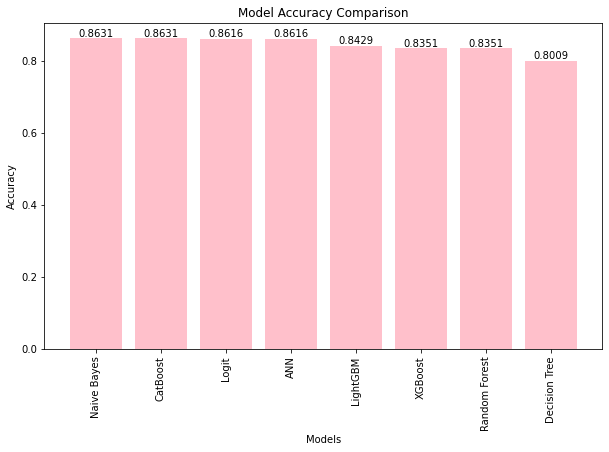

In [38]:
# Bar plot for model comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_comparison['Model'], model_comparison['Accuracy'], color='pink')

# Add the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()